In [1]:
import bandit as b
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from BaseAgent import AbstractAgent
np.random.seed(290)

C:\Users\saraa\AppData\Local\Temp\ipykernel_26632\313546155.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Multi-Armed Bandits: 

Three medicine where the effectiveness varies randomly over time. 

non-stationary MAB scenario? bc the reward distributions are changing over time.

In [2]:
bandit_final_env =b.Bandits_final()

In [3]:
bandit_final_env.reset()
bandit_final_env.step(0)
bandit_final_env.step(0)
bandit_final_env.step(2)

bandit_final_env.reset()
bandit_final_env.step(1)
bandit_final_env.step(2)
bandit_final_env.step(1)

bandit_final_env.reset()
# @shania burde kanskje lage ny env for hver ny window paramter og sånt...
# bare reset() ser ut til å huske ting fra forrige run

(None, 0, False, False, {'steps': 6})

In [4]:
#@shania this and next not same...
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 2.2933785872233985, True, False, {'steps': 1})

In [5]:
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 1.2798418929944861, True, False, {'steps': 1})

In [6]:
#@shania but this and next do be the same!
# gjør at det er helt likt med nye means og sånt for hver av paramterne du prøver
np.random.seed(290)
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 3.4770007318359246, True, False, {'steps': 1})

In [7]:
np.random.seed(290)
bandit_final_env =b.Bandits_final()
bandit_final_env.reset()
bandit_final_env.step(0)

(None, 3.4770007318359246, True, False, {'steps': 1})

The agent implements a variant of the Upper Confidence Bound (UCB) algorithm, a popular method in multi-armed bandit problems. It uses a sliding window mechanism to adapt to potentially non-stationary environments (where the properties of the environment can change over time).

1. Action Selection with UCB: This part calculates the Upper Confidence Bound for each action (or "arm") based on recent rewards. It balances exploration (trying new actions) and exploitation (using actions known to yield high rewards). Actions with fewer trials or high uncertainty get a "bonus" to their estimated value, encouraging exploration.
2. Sliding Window: This mechanism ensures that the agent's decisions are based on recent experiences by maintaining a fixed-size list of the most recent rewards for each action. This helps adapt to changes in the environment's dynamics.
3. Learning from Interaction: After performing an action and observing a reward, the agent updates its knowledge (the sliding windows of rewards)

In [8]:
class SlidingWindowUCB:
    def __init__(self, k, window_size=50, c=1):
        self.k = k
        self.window_size = window_size
        self.c = c
        self.windows = {i: [] for i in range(k)}
        self.t = 0
    
    def select_action(self):
        self.t += 1
        ucb_values = []
        for arm in range(self.k):
            rewards = self.windows[arm]
            if len(rewards) < 1:
                ucb_values.append(float('inf'))
            else:
                mean_reward = np.mean(rewards)
                bonus = self.c * np.sqrt(np.log(self.t) / len(rewards))
                ucb_values.append(mean_reward + bonus)
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        rewards = self.windows[action]
        if len(rewards) >= self.window_size:
            rewards.pop(0)
        rewards.append(reward)


In [9]:
def sliding_window_ucb(env, k, window_sizes, cs, num_episodes=2000,seed=42):
    results = {}
    for window_size in window_sizes:
        for c in cs:
            agent = SlidingWindowUCB(k=k, window_size=window_size, c=c)
            np.random.seed(seed)
            env=b.Bandits_final()
            total_rewards = 0
            rewards_per_episode = []  # Optional: track rewards for each episode
            obs, reward, terminated, _,_ = env.reset()  # Initial reset for each episode

            for episode in range(num_episodes):
                episode_reward = 0  # Reset episode reward
                

                #@shania blir terminated med en gang, så while kun en gang...
                # while not terminated:
                action = agent.select_action()
                _, reward, terminated, _, _ = env.step(action)
                agent.update(action, reward)
                episode_reward += reward
                
                total_rewards += episode_reward
                rewards_per_episode.append(episode_reward)  # Store episode reward

            avg_reward = total_rewards / num_episodes
            results[(window_size, c)] = {
                'total_rewards': total_rewards,
                'average_reward': avg_reward,
                'rewards_per_episode': rewards_per_episode
            }
            print(f"Window Size: {window_size}, c: {c}, Total Reward: {total_rewards}, Average Reward: {avg_reward}")

    return results

# Example usage of the function
env = bandit_final_env  # This should be your environment instance
k = 3  # Number of actions
window_sizes = [5,10,15]  # Different window sizes to test
# cs = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1,1.2,1.5,1.7, 2,2.5,5,7.5,10,12,15,17,20]  # Different values of exploration parameter c to test
cs=[0.5,1,1.5]
test_results = sliding_window_ucb(env, k, window_sizes, cs)


Window Size: 5, c: 0.5, Total Reward: 4629.589805188026, Average Reward: 2.314794902594013
Window Size: 5, c: 1, Total Reward: 6114.589805188014, Average Reward: 3.057294902594007
Window Size: 5, c: 1.5, Total Reward: 6214.589805188013, Average Reward: 3.1072949025940066
Window Size: 10, c: 0.5, Total Reward: 6038.589805188013, Average Reward: 3.0192949025940066
Window Size: 10, c: 1, Total Reward: 6498.589805188013, Average Reward: 3.2492949025940066
Window Size: 10, c: 1.5, Total Reward: 6489.589805188013, Average Reward: 3.2447949025940064
Window Size: 15, c: 0.5, Total Reward: 6452.589805188013, Average Reward: 3.2262949025940064
Window Size: 15, c: 1, Total Reward: 6027.589805188014, Average Reward: 3.013794902594007
Window Size: 15, c: 1.5, Total Reward: 6093.589805188011, Average Reward: 3.0467949025940055


In [10]:
import pandas as pd
df=pd.DataFrame(test_results).T
df.reset_index(inplace=True)
# df.drop('rewards_per_episode',axis=1,inplace=True)
df.sort_values('average_reward',ascending=False,inplace=True)
df.head(20)


,level_0,level_1,total_rewards,average_reward,rewards_per_episode
4,10,1.0,6498.589805,3.249295,"[3.905378998102028, 0.07117189996606732, 1.114..."
5,10,1.5,6489.589805,3.244795,"[3.905378998102028, 0.07117189996606732, 1.114..."
6,15,0.5,6452.589805,3.226295,"[3.905378998102028, 0.07117189996606732, 1.114..."
2,5,1.5,6214.589805,3.107295,"[3.905378998102028, 0.07117189996606732, 1.114..."
1,5,1.0,6114.589805,3.057295,"[3.905378998102028, 0.07117189996606732, 1.114..."
8,15,1.5,6093.589805,3.046795,"[3.905378998102028, 0.07117189996606732, 1.114..."
3,10,0.5,6038.589805,3.019295,"[3.905378998102028, 0.07117189996606732, 1.114..."
7,15,1.0,6027.589805,3.013795,"[3.905378998102028, 0.07117189996606732, 1.114..."
0,5,0.5,4629.589805,2.314795,"[3.905378998102028, 0.07117189996606732, 1.114..."


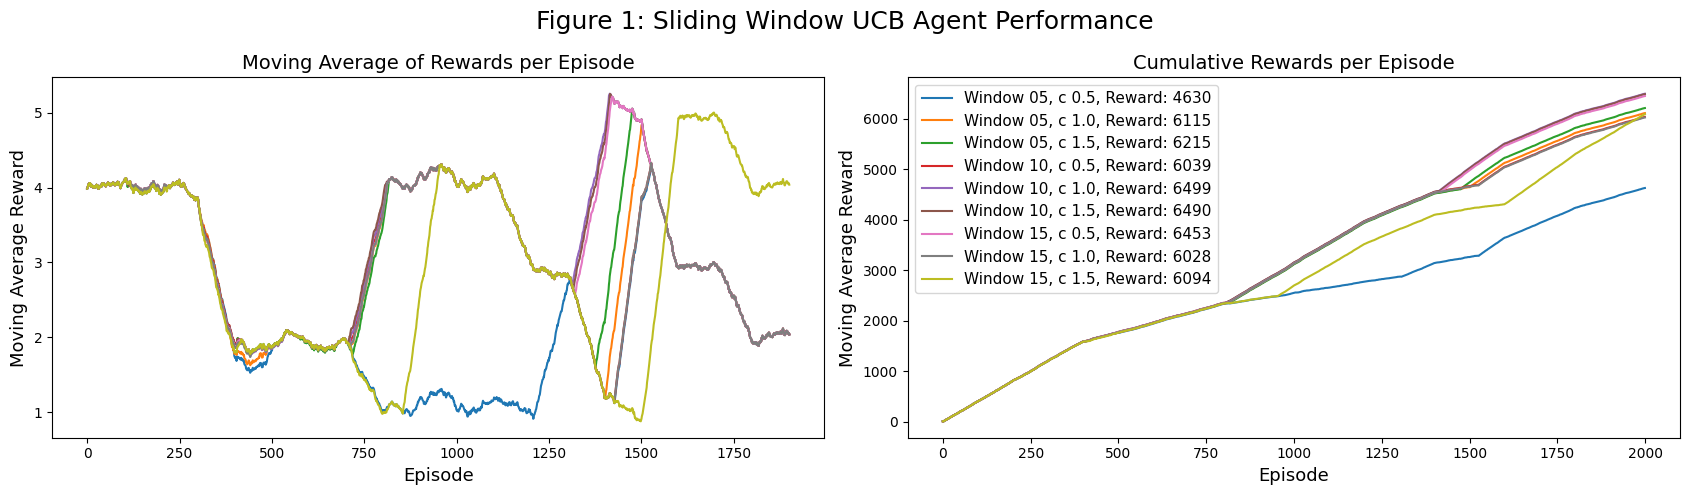

In [11]:

rolling_window = 100  

# Plotting setup 
fig, ax = plt.subplots(1,2, figsize=(17,5))

for (ws, c), data in test_results.items():
    rewards = np.array(data['rewards_per_episode'])
    # Compute the moving average using the convolve method
    moving_average = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
    # Plot each series with a label indicating the window size and c value
    ax[0].plot(moving_average, label=f"Window {ws}, c {c}")

# Chart formatting
ax[0].set_title('Moving Average of Rewards per Episode', fontsize=14)
ax[0].set_xlabel('Episode', fontsize=13)
ax[0].set_ylabel('Moving Average Reward', fontsize=13)


for (ws, c), data in test_results.items():
    rewards = np.array(data['rewards_per_episode'])
    # Compute the moving average using the convolve method
    cum_rewards = np.cumsum(rewards)
    # Plot each series with a label indicating the window size and c value
    ax[1].plot(cum_rewards, label=f"Window {'05' if ws==5 else ws}, c {'1.0' if c==1 else c}, Reward: {round(cum_rewards[-1])}")

# Chart formatting
ax[1].set_title('Cumulative Rewards per Episode', fontsize=14)
ax[1].set_xlabel('Episode', fontsize=13)
ax[1].set_ylabel('Moving Average Reward', fontsize=13)
ax[1].legend(fontsize=11)
fig.suptitle('Figure 1: Sliding Window UCB Agent Performance', fontsize=18)
plt.tight_layout()
plt.show()


In [12]:
#@shania oppg 3, #run the proposed solution *alongside* one of the standard MAB algorithms and compare"
# ser du har brukt sliding window med ucb, men er meningen å sammenligne slidingwindow+ucb med kun ucb og greedy etc?? eller slidingwindow+ucb med slidingwindow+greedy etc???
# altså TODO: find results to compare!!!

# Decay epsilon greedy:

In [13]:
def calculate_regret(mab, cumulative_reward, t, print_=False):
    if mab.state is not None:
        optimal_reward = mab.means[mab.state][mab.get_optimal_action()] * t
    else:
        optimal_reward = mab.means[mab.get_optimal_action()] * t
    #if print_:
       # print("optimal reward at time step", t, ":", optimal_reward)
        #print("cumulative reward at time step", t, ":", cumulative_reward)
    return optimal_reward - cumulative_reward

 
def update_expected_reward(expected_reward,action_count,current_action,reward):
    expected_reward[current_action]+=(1/action_count[current_action]) * (reward-expected_reward[current_action])

def get_confidence_bounds(t,action_count):
    return np.sqrt(2*np.log(t)/action_count)
## here i am calculating the 


In [14]:
def decaying_epsilon_greedy(mab,T,epsilon, alpha,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.ones(mab.k)*100
    action_count = np.zeros(mab.k)
    cumulative_rewards = 0
    rewards =[]
    
    for t in range(T):
        if np.random.uniform(0,1) < epsilon:
            current_action = np.random.randint(mab.k)
        else:
            current_action = np.argmax(expected_reward)
            
        current_state = mab.step(current_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        rewards.append(current_state[1])
        action_count[current_action] += 1
        update_expected_reward(expected_reward,action_count,current_action,current_state[1])
        epsilon*=alpha
    
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])

    regret = calculate_regret(mab, cumulative_rewards, T,print_)
    

    if print_:
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret, rewards

In [15]:
print(decaying_epsilon_greedy(bandit_final_env,1000,0.5,0.99))

(1, 602.6969346686265, [3.3738099677784334, 4.0153789813721055, -0.9670682434720708, 6.43776958805973, -0.16944923748336765, 4.149597478073554, 4.858513153447497, 4.1513976878932075, 4.39046484992889, 3.8967782470675036, 5.568778604102849, 2.671903737566252, 0.5500950570276945, -0.3600321146548607, 2.9446129829075125, 1.0584845435303247, 1.574785722127399, 3.9698283333708653, 4.288126236727704, 3.166164816560198, -0.4532484090230134, 5.452467534470745, 4.622207144043402, 2.861166882219231, 4.670480617241212, 2.9281427669598443, 0.37216868147209525, 3.412502185028257, 4.192292978141896, -0.14822287759177039, 4.514400936570437, 4.589722092741383, 3.7714000846599816, 3.0056506253914876, 6.412615421612916, 0.7846042878980238, 3.8908914823474308, 3.5114024180073358, 3.134133562870941, -0.7192433379629661, 3.808294086102863, 3.308382430181099, 0.1018562952619867, 5.549020151495188, 4.164760841236517, 4.050887701856018, 0.3712128680568303, 5.15323857854524, 3.6041712192683377, 3.8203759997647

In [16]:
def epsilon_greedy(mab,T,epsilon,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.ones(mab.k)*1000
    action_count = np.zeros(mab.k)
    cumulative_rewards = 0
    rewards = []
    regret2 = np.zeros(T)
    
    for t in range(T):
        if np.random.uniform(0,1) < epsilon:
            current_action = np.random.randint(mab.k)
        else:
            current_action = np.argmax(expected_reward)
            
        current_state = mab.step(current_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        rewards.append(current_state[1])
        action_count[current_action] += 1
        update_expected_reward(expected_reward,action_count,current_action,current_state[1])
        regret2[t] = calculate_regret(mab, cumulative_rewards, t,print_)
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])
            
        
    regret = calculate_regret(mab, cumulative_rewards, T,print_)   

    if print_:
        # print("regert", regret2)
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret,rewards


In [17]:
def ucb(mab,T,c,print_=False):
    mab.reset()

    # initialise the expected reward and action count and cumulative reward
    expected_reward = np.zeros(mab.k)
    action_count = np.zeros(mab.k)
    cumulative_rewards =0
    rewards = []

    # initialisation, pull each arm once and use the rewards to initialise the expected reward and action count
    # OBS! not a smart thing to do in real hospital setting, with trying drugs on patients ...
    # (needed to avoid dividing by zero in the first iteration)
    for i in range(mab.k):
        expected_reward[i] = mab.step(i)[1]
        action_count[i] += 1
        rewards.append(expected_reward[i])
    
    for t in range(mab.k+1,T+1):
        confidence_bounds = get_confidence_bounds(t,action_count)
        best_action = np.argmax(expected_reward + c*confidence_bounds)

        current_state = mab.step(best_action)        # maybe not state...
        cumulative_rewards += current_state[1]
        rewards.append(current_state[1])
        action_count[best_action] += 1
        update_expected_reward(expected_reward,action_count,best_action,current_state[1])
    
    if print_:
        for i in range(mab.k):
            print("Expected reward action", i, ":", expected_reward[i], "Action count:", action_count[i])
        
    regret = calculate_regret(mab, cumulative_rewards, T,print_)   

    if print_:
        print('-------------------------------------\n\n')

    return np.argmax(expected_reward), regret,rewards

ucb(bandit_final_env,1000,0.5)

(2,
 -328.88547057961705,
 [1.9026316810289334,
  2.5230750724680986,
  3.2606285925409635,
  5.191899334413573,
  4.950015828669645,
  4.243004722054399,
  2.467299440110069,
  3.8037193486120633,
  4.301700008901736,
  4.175536229578598,
  2.1562064165192543,
  3.1096821519801283,
  3.9359222358512835,
  4.53629090951719,
  1.8038721789000536,
  3.8378760245201415,
  4.143048769878952,
  4.849611988516213,
  4.692857584237437,
  4.582571318808805,
  3.200059493298066,
  2.0919978628766924,
  3.606947242938599,
  5.00163182520856,
  5.393454527524431,
  4.710549102297786,
  4.429340822801734,
  4.379639648385965,
  3.4438812532392196,
  3.86993970644638,
  5.669069525826331,
  3.0574419942081237,
  5.614778790709852,
  3.6779718455079418,
  5.325432109095079,
  2.5931849905024618,
  4.585904201164649,
  3.263229864052378,
  2.5847328080758123,
  4.218534042410946,
  5.0094717885959685,
  3.155058561406504,
  2.5009840395415988,
  3.908155235665045,
  3.912564671222819,
  4.54831962755

In [18]:
def run_experiments(mab, T, epsilon, alpha, c, print_=False):
    eps_greed=epsilon_greedy(mab,T,epsilon,print_)
    
    
    dec_greed=decaying_epsilon_greedy(mab,T,epsilon,alpha,print_)
    ucb_res=ucb(mab,T,c,print_)
    
    
    if print_:
        print(f'epsilon greedy:          medicine: {eps_greed[0]}  regret: {eps_greed[1]}')
        print(f'decaying epsiol greedy:  medicine: {dec_greed[0]}  regret: {dec_greed[1]}')
        print(f'ucb:                     medicine: {ucb_res[0]}  regret: {ucb_res[1]}')
        
        print('-------------------------------------\n')
    return eps_greed,dec_greed,ucb_res

run_experiments(bandit_final_env,1000,0.5,0.99,0.5,True)

Expected reward action 0 : 3.093452943665569 Action count: 412.0
Expected reward action 1 : 2.130997140639763 Action count: 168.0
Expected reward action 2 : 1.9466773195082945 Action count: 420.0
-------------------------------------


Expected reward action 0 : 3.914747770728949 Action count: 206.0
Expected reward action 1 : 3.903158774208794 Action count: 59.0
Expected reward action 2 : 4.090678022136582 Action count: 735.0
-------------------------------------


Expected reward action 0 : 0.635709904107589 Action count: 1.0
Expected reward action 1 : 3.7779319136577025 Action count: 482.0
Expected reward action 2 : 3.839935851844109 Action count: 517.0
-------------------------------------


epsilon greedy:          medicine: 0  regret: 2549.88539338882
decaying epsiol greedy:  medicine: 2  regret: 956.6272452811281
ucb:                     medicine: 2  regret: 202.7167584192157
-------------------------------------



((0,
  2549.88539338882,
  [0.9696458781363508,
   0.7940963749594439,
   1.934010886461071,
   3.800157962585735,
   -0.3918767653868664,
   -0.017764309076953033,
   1.8270161485346066,
   1.2653360784670094,
   2.1038695320274874,
   3.3034371862498237,
   4.332076192716774,
   1.1389600706678853,
   2.578522252694227,
   1.8689576257041147,
   3.890522177645469,
   3.3659093379148275,
   3.097913737608642,
   2.100987444615699,
   1.861941681344733,
   3.3644797278464913,
   2.9250103808727794,
   2.142432425853856,
   2.568646073080714,
   2.8961933188656626,
   4.937554301962338,
   -2.658476431854212,
   3.389169810223448,
   1.000708627680522,
   4.197792522142378,
   1.2447145768184085,
   1.7409343740692538,
   3.7870165696408917,
   4.3857894223598075,
   3.1879147111919175,
   -0.11999143027161652,
   0.8263709667623493,
   0.6812516847538669,
   1.970188151458155,
   -0.32659082745082735,
   0.8311199979939045,
   1.9368266442606499,
   3.414632895241338,
   4.087102362015

In [19]:
seed=11
np.random.seed(seed)
env=b.Bandits_final()
sliding_ucb_dict=sliding_window_ucb(env,3,[10], [1],num_episodes=2000,seed=seed)
slide_rewards=sliding_ucb_dict[(10,1)]['rewards_per_episode']

np.random.seed(seed)
env=b.Bandits_final()
eps_gre_rewards=epsilon_greedy(env,2000,0.5)[2]

np.random.seed(seed)
env=b.Bandits_final()
dec_gre_rewards=decaying_epsilon_greedy(env,2000,0.5,0.99)[2]

np.random.seed(seed)
env=b.Bandits_final()
ucb_rewards=ucb(env,2000,1)[2]


Window Size: 10, c: 1, Total Reward: 9120.429324281775, Average Reward: 4.560214662140887


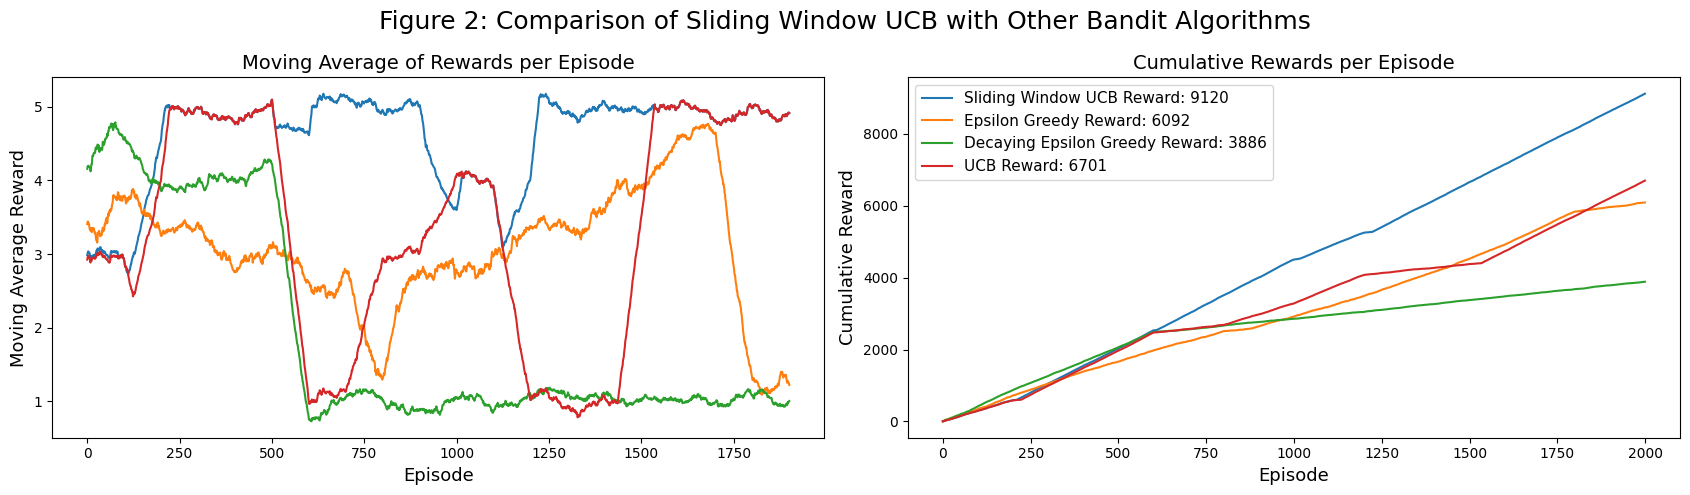

In [20]:

fig, ax = plt.subplots(1,2, figsize=(17,5))
rolling_window = 100

for rewards, label in zip([slide_rewards,eps_gre_rewards,dec_gre_rewards,ucb_rewards],['Sliding Window UCB','Epsilon Greedy','Decaying Epsilon Greedy','UCB']):
    moving_average = np.convolve(rewards, np.ones(rolling_window)/rolling_window, mode='valid')
    ax[0].plot(moving_average, label=label)
    ax[1].plot(np.cumsum(rewards), label=label+' Reward: '+str(round(np.sum(rewards))))

ax[0].set_title('Moving Average of Rewards per Episode', fontsize=14)
ax[0].set_xlabel('Episode', fontsize=13)
ax[0].set_ylabel('Moving Average Reward', fontsize=13)
# ax[0].legend()

ax[1].set_title('Cumulative Rewards per Episode', fontsize=14)
ax[1].set_xlabel('Episode', fontsize=13)
ax[1].set_ylabel('Cumulative Reward', fontsize=13)
ax[1].legend(fontsize=11)

fig.suptitle('Figure 2: Comparison of Sliding Window UCB with Other Bandit Algorithms', fontsize=18)
plt.tight_layout()
plt.show()

In [21]:
epsilon_greedy(bandit_final_env,2000,0.5)

(2,
 2349.4154171212203,
 [4.807760809507423,
  0.7706703262150247,
  3.7406392892107183,
  3.470947325648375,
  4.952473972192733,
  2.9986077259755497,
  5.365068526879401,
  4.439364222734604,
  2.2102979112043197,
  5.406187424945885,
  2.622074453852454,
  2.3496655305332093,
  1.889782792362714,
  4.128175886375641,
  4.517038197012468,
  5.105486933591598,
  5.385355666968006,
  3.708887199164125,
  3.468436856832734,
  4.483145066703881,
  4.189969345754422,
  4.706410247282182,
  4.260125611517601,
  3.758085431852088,
  -0.08426470059551439,
  4.730022012493376,
  4.344041969965298,
  3.980882757898641,
  3.954297925574735,
  5.477023543433873,
  5.002131830154193,
  4.275637540205413,
  5.176884607569978,
  2.5028107146472296,
  3.412452647104694,
  2.8688031101408713,
  3.7574706017559825,
  3.9392192160540667,
  4.342636035141957,
  4.734809136320208,
  4.781363779842414,
  5.258068245880246,
  1.0686591843272726,
  4.039075106897859,
  3.410733307059752,
  3.2801022873987